# Compute the optimal temporal lag in each spatial region

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils
import plotting as plot

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
# Setup
spatial_res = 5
temporal_res = "1D"
lag_bnds = (0, 6*30)
tau = 30

temporal_names = ["daily", "days"]

In [5]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [6]:
# Cut datasets to a regular grid and resample to temporal averages within each grid cell
df_sif = (
    utils.regrid(DS_sif, res=spatial_res)
    .groupby(["lon", "lat"])
    .resample(temporal_res)
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2 = (
    utils.regrid(DS_xco2, res=spatial_res)
    .groupby(["lon", "lat"])
    .resample(temporal_res)
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
df_grid = pd.merge(df_sif, df_xco2, on=["lon", "lat", "time"], how="outer")
df_grid

,lon,lat,time,sif,xco2
0,-177.5,-87.5,2014-11-27,0.071730,NaN
1,-177.5,-87.5,2014-11-28,NaN,NaN
2,-177.5,-87.5,2014-11-29,0.058615,NaN
3,-177.5,-87.5,2014-11-30,-0.068265,NaN
4,-177.5,-87.5,2014-12-01,NaN,NaN
...,...,...,...,...,...
2845293,167.5,-42.5,2014-09-16,NaN,NaN
2845294,167.5,-42.5,2014-09-17,NaN,NaN
2845295,167.5,-42.5,2014-09-18,NaN,NaN
2845296,167.5,-42.5,2014-09-19,NaN,NaN


In [7]:
# Convert to dataset and compute optimal lags
DS_grid = (
    df_grid
    .set_index(["lon", "lat", "time"])
    .to_xarray()
)

DS_grid = xarray.merge([
    DS_grid, 
    stats.optim_lag_nd(DS_grid.xco2, DS_grid.sif, lag_bnds=lag_bnds, tau=tau)
])

DS_grid

<xarray.Dataset>
Dimensions:    (lat: 35, lon: 72, time: 2156)
Coordinates:
  * lon        (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat        (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 67.5 72.5 77.5 82.5
  * time       (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2020-07-31
Data variables:
    sif        (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    xco2       (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    optim_lag  (lon, lat) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    xcor       (lon, lat) float64 nan nan nan nan nan ... -0.2667 nan nan nan

/home/josh/Projects/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  


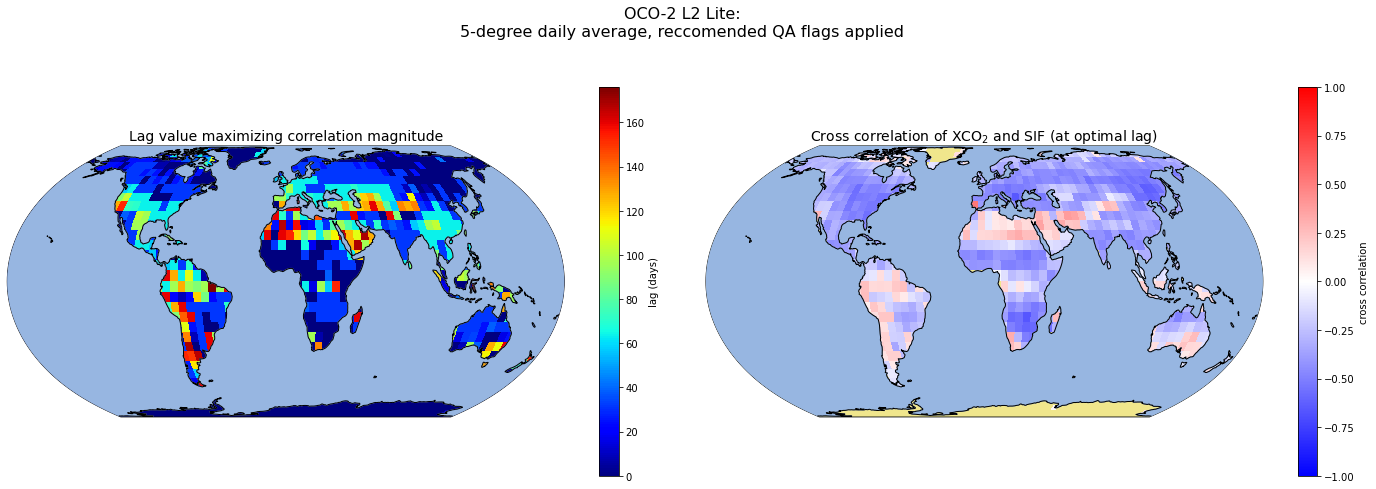

In [8]:
fig = plt.figure(figsize=(25, 8))
gs = fig.add_gridspec(100, 100)

# Define color map with nans set to khaki
cmap = plt.get_cmap("bwr")
cmap.set_bad("khaki")

fig.subplots_adjust(top=0.8)
fig.suptitle(
    "OCO-2 L2 Lite:\n"
    f"{spatial_res}-degree {temporal_names[0]} average, reccomended QA flags applied",
    size=16, y=0.94
)

# Counts
ax1 = fig.add_subplot(gs[:, 0:50], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid.optim_lag,
    title="Lag value maximizing correlation magnitude",
    ax=ax1,
    cbar_kwargs={"label": f"lag ({temporal_names[1]})"},
    cmap=plt.cm.get_cmap("jet", np.arange(*lag_bnds).size),
    robust=False
)

ax2 = fig.add_subplot(gs[:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid.xcor,
    title="Cross correlation of XCO$_2$ and SIF (at optimal lag)",
    ax=ax2,
    vmin=-1, vmax=1,
    cmap="bwr",
    cbar_kwargs={"label": "cross correlation"}
)

fig.savefig(f"../plots/{spatial_res}deg_{temporal_names[0]}_optimal_lag.png");